In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

tickers = ['AAPL', 'MSFT', 'TSLA', 'GOOGL', 'AMZN', 'NVDA', 'META']
data_dict = {}

for ticker in tickers:
    file_path = f"../data/{ticker}_merged.csv"
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, parse_dates=["Date"])
        # clean
        df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
        df["sentiment_score"] = pd.to_numeric(df["sentiment_score"], errors="coerce")
        df.dropna(subset=["Date", "Close"], inplace=True)
        df = df[df["Date"].dt.year == 2025]  # focus only 2025
        data_dict[ticker] = df
        print(f"{ticker} loaded: {df.shape}")
    else:
        print(f"{ticker}_merged.csv not found!")


In [ ]:
for ticker, df in data_dict.items():
    print(f"\n---- {ticker} preview ----")
    print(df.head())
    plt.figure(figsize=(10,4))
    plt.plot(df["Date"], df["Close"], label="Close")
    plt.xlabel("Date")
    plt.ylabel("Close")
    plt.title(f"{ticker} Close price 2025")
    plt.show()
    

In [ ]:
def train_lstm_with_sentiment(df, ticker):
    from sklearn.metrics import mean_squared_error
    import math

    # features: price + sentiment
    features = df[["Close", "sentiment_score"]].fillna(0)
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(features)

    sequence_length = 60
    x, y = [], []

    for i in range(sequence_length, len(scaled_features)):
        x.append(scaled_features[i-sequence_length:i])
        y.append(scaled_features[i, 0])  # predict next close price

    x = np.array(x)
    y = np.array(y)

    if len(x) < 10:
        print(f"{ticker}: not enough data after merging, skipping")
        return

    # split
    split = int(len(x) * 0.8)
    x_train, y_train = x[:split], y[:split]
    x_test, y_test = x[split:], y[split:]

    # LSTM
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mean_squared_error")

    model.summary()

    history = model.fit(
        x_train, y_train,
        epochs=20,
        batch_size=32,
        validation_data=(x_test, y_test),
        verbose=1
    )

    pred = model.predict(x_test)
    # inverse only price
    scaled_price = np.zeros((len(pred), 2))
    scaled_price[:,0] = pred.flatten()
    pred_price = scaler.inverse_transform(scaled_price)[:,0]

    true_price = scaler.inverse_transform(np.concatenate([y_test.reshape(-1,1), np.zeros_like(y_test.reshape(-1,1))], axis=1))[:,0]

    # plot
    plt.figure(figsize=(12,6))
    plt.plot(true_price, label="Actual")
    plt.plot(pred_price, label="Predicted")
    plt.title(f"{ticker} Close price prediction with sentiment (2025)")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

    rmse = math.sqrt(mean_squared_error(true_price, pred_price))
    print(f"RMSE for {ticker}: {rmse}")

    # save
    model.save(f"../models/{ticker}_lstm_sentiment.h5")
    print(f"Saved sentiment-LSTM model for {ticker}")


In [ ]:
for ticker, df in data_dict.items():
    print(f"\n---- Running sentiment-LSTM for {ticker} ----")
    train_lstm_with_sentiment(df, ticker)



---- Running sentiment-enhanced LSTM for AAPL ----


c:\Users\adity\OneDrive\Desktop\AI-Stock-Prediction-Tool\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                  │ (None, 60, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,851 (120.51 KB)

 Trainable params: 30,851 (120.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 310ms/step - loss: 0.2584 - val_loss: 0.0532
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1403 - val_loss: 0.0165
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0635 - val_loss: 0.0032
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0285 - val_loss: 0.0179
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0224 - val_loss: 0.0460
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0359 - val_loss: 0.0415
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0338 - val_loss: 0.0230
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0183 - val_loss: 0.0105
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0168 - val_loss: 0.0052
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0186 - val_loss: 0.0040
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0211 - val_loss: 0.0041
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0209 - val_loss: 0.0042


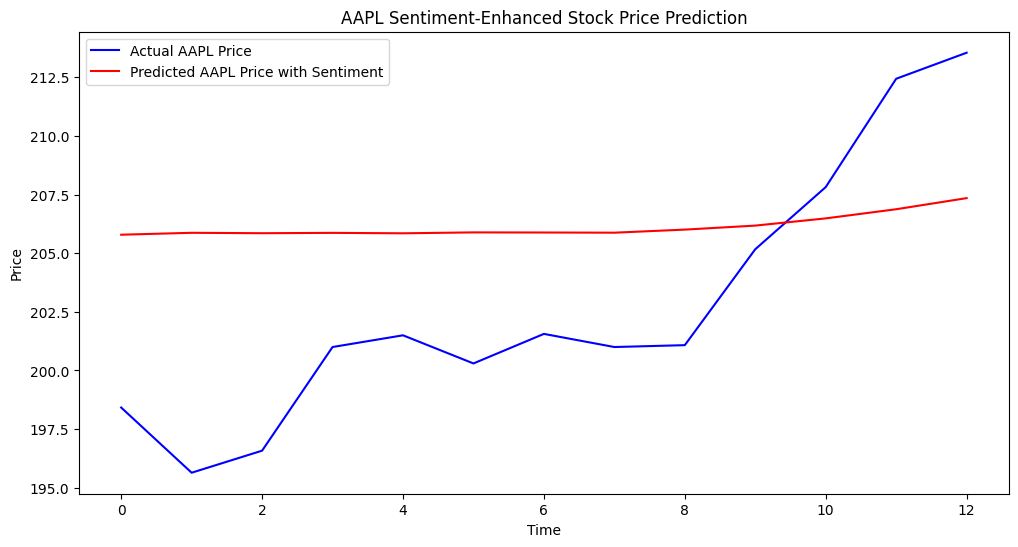

Sentiment-enhanced RMSE for AAPL: 5.9341
Sentiment-enhanced model saved to ../models/AAPL_lstm_model_sentiment.h5

---- Running sentiment-enhanced LSTM for MSFT ----


c:\Users\adity\OneDrive\Desktop\AI-Stock-Prediction-Tool\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                  │ (None, 60, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,851 (120.51 KB)

 Trainable params: 30,851 (120.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 291ms/step - loss: 0.3297 - val_loss: 0.4851
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.1813 - val_loss: 0.1989
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0823 - val_loss: 0.0236
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0340 - val_loss: 0.0339
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0364 - val_loss: 0.1159
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0558 - val_loss: 0.0686
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0370 - val_loss: 0.0132
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0250 - val_loss: 0.0013
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0207 - val_loss: 0.0116
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0238 - val_loss: 0.0222
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0256 - val_loss: 0.0243
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0283 - val_loss: 0.0182


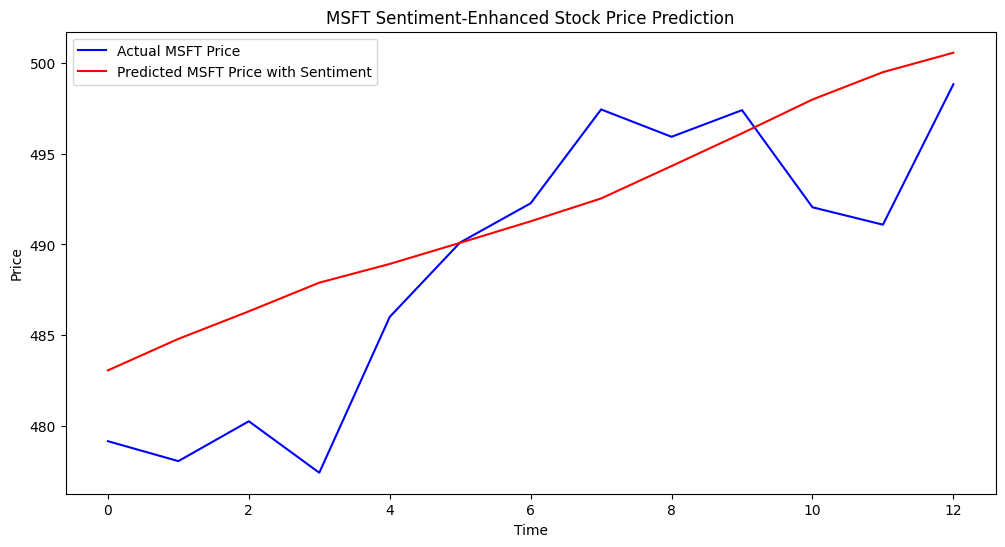

Sentiment-enhanced RMSE for MSFT: 5.2240
Sentiment-enhanced model saved to ../models/MSFT_lstm_model_sentiment.h5

---- Running sentiment-enhanced LSTM for TSLA ----


c:\Users\adity\OneDrive\Desktop\AI-Stock-Prediction-Tool\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_32 (LSTM)                  │ (None, 60, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,851 (120.51 KB)

 Trainable params: 30,851 (120.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 296ms/step - loss: 0.1962 - val_loss: 0.1222
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.1359 - val_loss: 0.0726
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0889 - val_loss: 0.0326
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0571 - val_loss: 0.0067
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0327 - val_loss: 0.0099
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0210 - val_loss: 0.0520
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0274 - val_loss: 0.0636
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0299 - val_loss: 0.0339
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0239 - val_loss: 0.0094
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0184 - val_loss: 0.0029
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0172 - val_loss: 0.0067
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0184 - val_loss: 0.0125


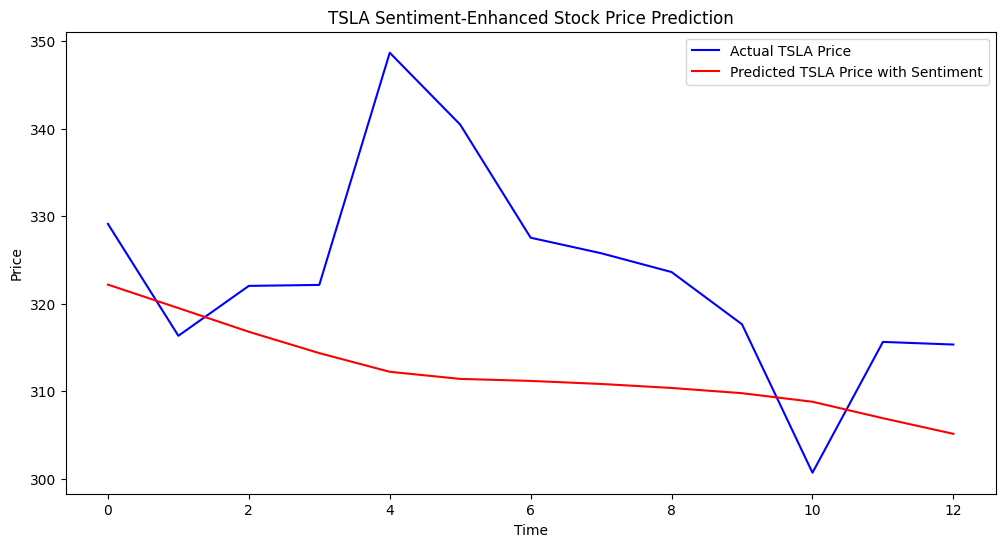

Sentiment-enhanced RMSE for TSLA: 15.9111
Sentiment-enhanced model saved to ../models/TSLA_lstm_model_sentiment.h5

---- Running sentiment-enhanced LSTM for GOOGL ----


c:\Users\adity\OneDrive\Desktop\AI-Stock-Prediction-Tool\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_34 (LSTM)                  │ (None, 60, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,851 (120.51 KB)

 Trainable params: 30,851 (120.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 288ms/step - loss: 0.0894 - val_loss: 0.1021
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0448 - val_loss: 0.0380
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0216 - val_loss: 0.0074
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0195 - val_loss: 0.0124
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0264 - val_loss: 0.0080
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0171 - val_loss: 0.0084
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0143 - val_loss: 0.0112
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0144 - val_loss: 0.0124
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0140 - val_loss: 0.0111
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0135 - val_loss: 0.0086
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0126 - val_loss: 0.0073
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0114 - val_loss: 0.0086

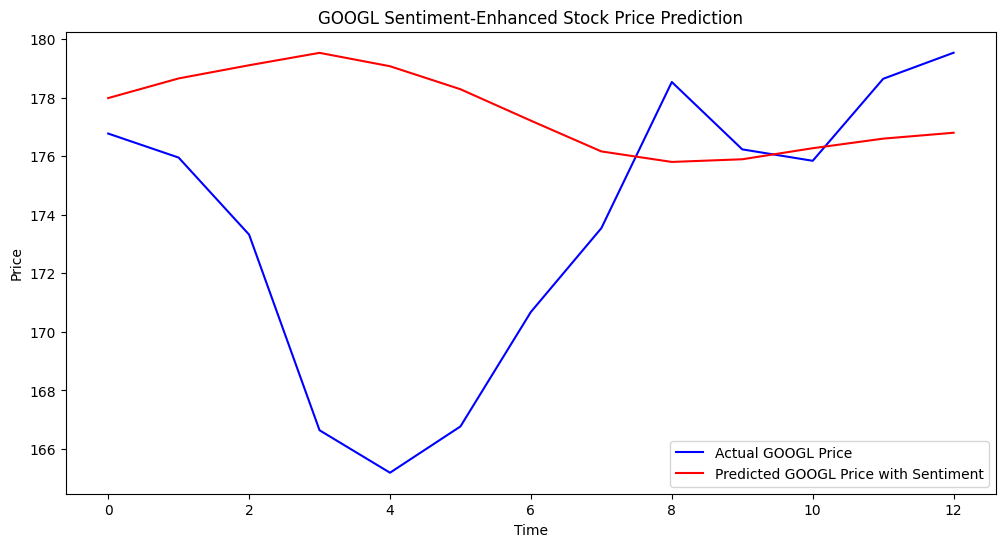

Sentiment-enhanced RMSE for GOOGL: 6.8067
Sentiment-enhanced model saved to ../models/GOOGL_lstm_model_sentiment.h5

---- Running sentiment-enhanced LSTM for AMZN ----


c:\Users\adity\OneDrive\Desktop\AI-Stock-Prediction-Tool\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_36 (LSTM)                  │ (None, 60, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,851 (120.51 KB)

 Trainable params: 30,851 (120.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step - loss: 0.1949 - val_loss: 0.2481
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.1225 - val_loss: 0.0965
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0662 - val_loss: 0.0116
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0313 - val_loss: 0.0204
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0323 - val_loss: 0.0613
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0445 - val_loss: 0.0432
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0299 - val_loss: 0.0188
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0203 - val_loss: 0.0060
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0211 - val_loss: 0.0031
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0216 - val_loss: 0.0037
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0234 - val_loss: 0.0038
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0235 - val_loss: 0.0033


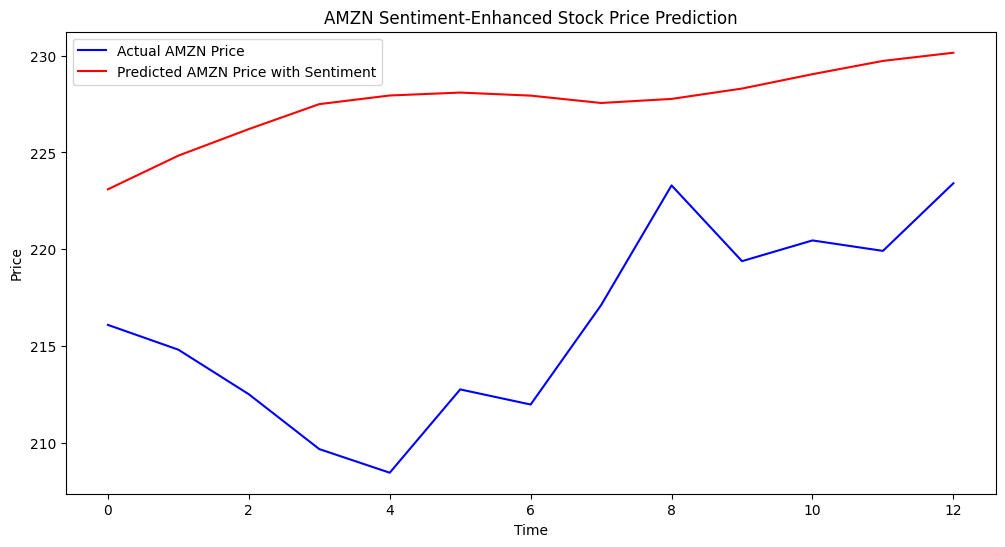

Sentiment-enhanced RMSE for AMZN: 12.2318
Sentiment-enhanced model saved to ../models/AMZN_lstm_model_sentiment.h5

---- Running sentiment-enhanced LSTM for NVDA ----


c:\Users\adity\OneDrive\Desktop\AI-Stock-Prediction-Tool\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_38 (LSTM)                  │ (None, 60, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_39 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,851 (120.51 KB)

 Trainable params: 30,851 (120.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 290ms/step - loss: 0.2207 - val_loss: 0.5547
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1208 - val_loss: 0.2393
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0553 - val_loss: 0.0268
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0340 - val_loss: 0.0131
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0531 - val_loss: 0.0092
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0404 - val_loss: 0.0032
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0259 - val_loss: 0.0174
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0223 - val_loss: 0.0329
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0246 - val_loss: 0.0390
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0270 - val_loss: 0.0327
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0244 - val_loss: 0.0194
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0204 - val_loss: 0.0074


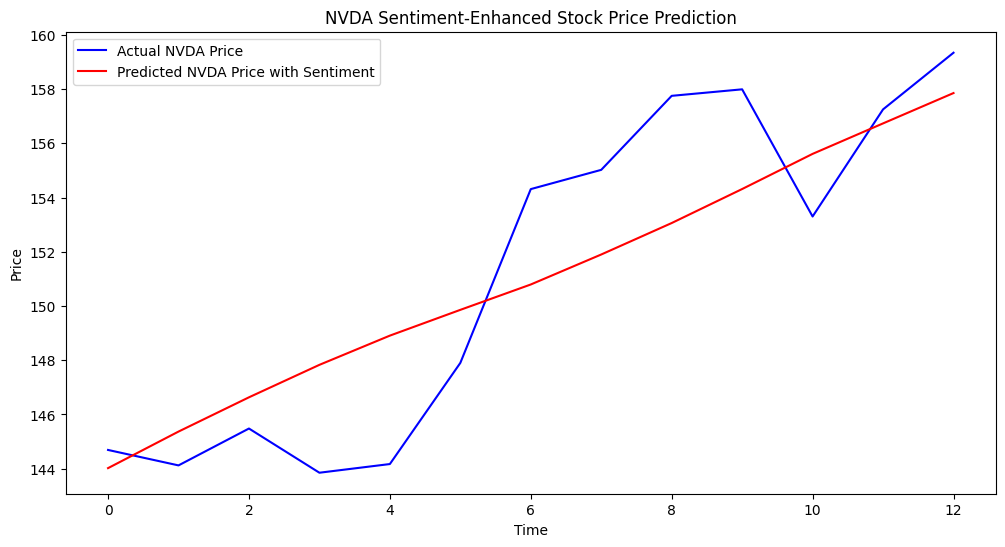

Sentiment-enhanced RMSE for NVDA: 2.9206
Sentiment-enhanced model saved to ../models/NVDA_lstm_model_sentiment.h5

---- Running sentiment-enhanced LSTM for META ----


c:\Users\adity\OneDrive\Desktop\AI-Stock-Prediction-Tool\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_40 (LSTM)                  │ (None, 60, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,851 (120.51 KB)

 Trainable params: 30,851 (120.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 393ms/step - loss: 0.3153 - val_loss: 0.6662
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.2060 - val_loss: 0.3424
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.1048 - val_loss: 0.0895
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0508 - val_loss: 0.0032
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0544 - val_loss: 0.0245
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0724 - val_loss: 0.0077
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.0435 - val_loss: 0.0032
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0324 - val_loss: 0.0176
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0306 - val_loss: 0.0340
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0333 - val_loss: 0.0396
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0318 - val_loss: 0.0331
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0327 - val_loss: 0.019

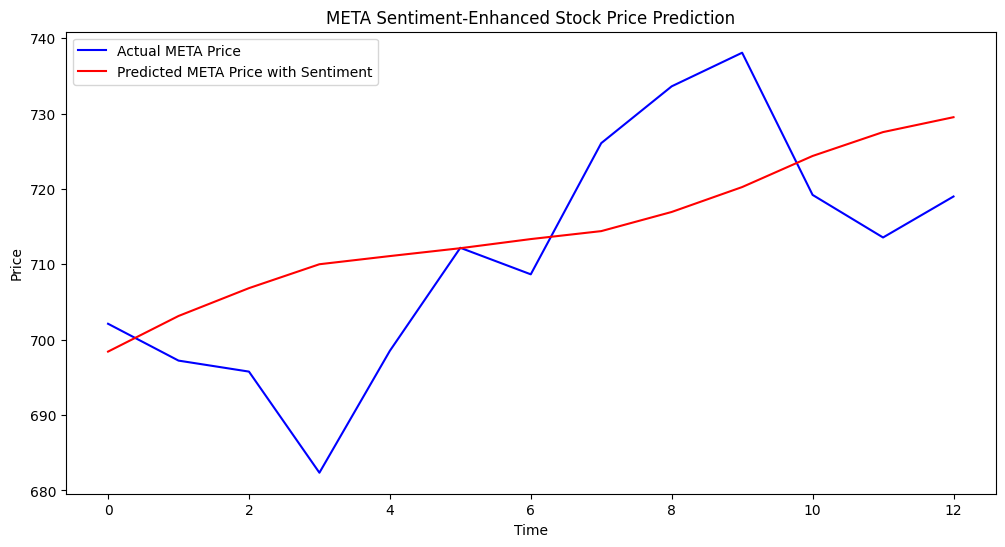

Sentiment-enhanced RMSE for META: 12.9561
Sentiment-enhanced model saved to ../models/META_lstm_model_sentiment.h5


In [23]:
import numpy as np
import pandas as pd
import os
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

tickers = ['AAPL', 'MSFT', 'TSLA', 'GOOGL', 'AMZN', 'NVDA', 'META']

for ticker in tickers:
    print(f"\n---- Running sentiment-enhanced LSTM for {ticker} ----")

    merged_path = f"../data/{ticker}_merged.csv"
    if not os.path.exists(merged_path):
        print(f"{merged_path} not found, skipping.")
        continue

    df = pd.read_csv(merged_path, parse_dates=["Date"])

    # Use 2025 data only if you wish, or the entire data:
    df = df[df["Date"].dt.year == 2025]

    if len(df) < 100:
        print(f"Not enough data for {ticker}, skipping (only {len(df)} rows).")
        continue

    # fill NaN sentiment with neutral 0
    df["sentiment_score"] = df["sentiment_score"].fillna(0)

    # features: [close price, sentiment score]
    features = df[["Close", "sentiment_score"]].values

    # scale features between 0 and 1
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(features)

    # sequence generation
    x, y = [], []
    seq_len = 60
    for i in range(seq_len, len(scaled_features)):
        x.append(scaled_features[i-seq_len:i])
        y.append(scaled_features[i, 0])  # predict close price only

    x, y = np.array(x), np.array(y)

    train_size = int(len(x) * 0.8)
    x_train, y_train = x[:train_size], y[:train_size]
    x_test, y_test = x[train_size:], y[train_size:]

    # build LSTM
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mean_squared_error")
    model.summary()

    history = model.fit(
        x_train, y_train,
        epochs=20,
        batch_size=32,
        validation_data=(x_test, y_test),
        verbose=1
    )

    # predictions
    pred = model.predict(x_test)
    # invert only close price
    pred_prices = scaler.inverse_transform(np.hstack([pred.reshape(-1, 1), np.zeros_like(pred.reshape(-1, 1))]))[:,0]
    real_prices = scaler.inverse_transform(np.hstack([y_test.reshape(-1, 1), np.zeros_like(y_test.reshape(-1, 1))]))[:,0]

    # plot
    plt.figure(figsize=(12,6))
    plt.plot(real_prices, color='blue', label=f"Actual {ticker} Price")
    plt.plot(pred_prices, color='red', label=f"Predicted {ticker} Price with Sentiment")
    plt.title(f"{ticker} Sentiment-Enhanced Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

    rmse = math.sqrt(mean_squared_error(real_prices, pred_prices))
    print(f"Sentiment-enhanced RMSE for {ticker}: {rmse:.4f}")

    # save
    model.save(f"../models/{ticker}_lstm_model_sentiment.h5")
    print(f"Sentiment-enhanced model saved to ../models/{ticker}_lstm_model_sentiment.h5")
